# PyMC3 interface

In this notebook, we show how to use PyMC3 together with pyPESTO problems, without using the pyPESTO specific interface.

## Example problem (ODE)

We will use a toy example of a conversion reaction, implemented in the [PEtab](https://github.com/petab-dev/petab) format.

In [1]:
import pypesto
import pypesto.petab
import petab

from pypesto import optimize
from pypesto import visualize

# import to petab
petab_problem = petab.Problem.from_yaml("conversion_reaction/conversion_reaction.yaml")
# import to pypesto
importer = pypesto.petab.PetabImporter(petab_problem)
# create problem
importer.create_model(force_compile=True, verbose=False)
problem = importer.create_problem()

Commonly, as a first step, optimization is performed, in order to find good parameter point estimates.

In [2]:
%%time
result = optimize.minimize(problem, n_starts=10)

CPU times: user 2.57 s, sys: 338 ms, total: 2.91 s
Wall time: 2.6 s


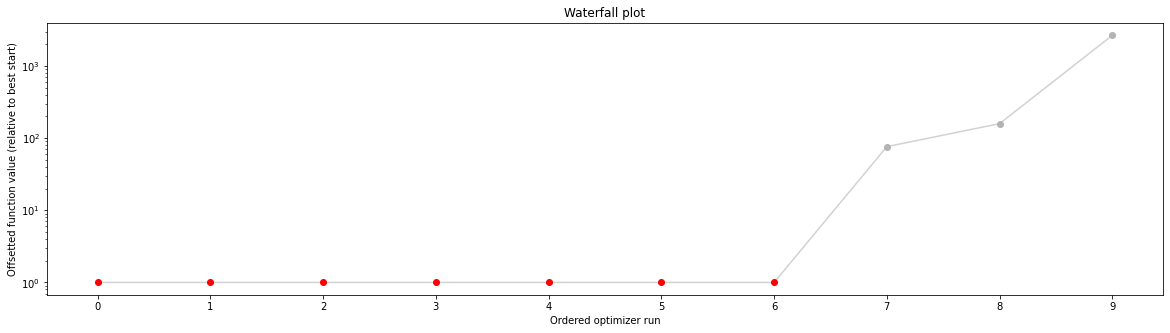

In [3]:
ax = visualize.waterfall(result, size=(20, 5))

### Creating a PyMC3 model from the pyPESTO problem

We will create a PyMC3 problem whose posterior distribution is the same as the one of the pyPESTO problem.

As the test value (default start value for sampling) we will use the best parameters obtained in the multi-start optimization.

This model can then be used with standard PyMC3 functions.

In [4]:
from pypesto.sample.pymc3_interface import create_pymc3_model
x0 = result.optimize_result.list[0]['x']
model = create_pymc3_model(problem, x0)

In [5]:
from pymc3 import sample, traceplot
with model:
    trace = sample(1000, tune=1500, discard_tuned_samples=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 67 seconds.
The acceptance probability does not match the target. It is 0.5276712606616857, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


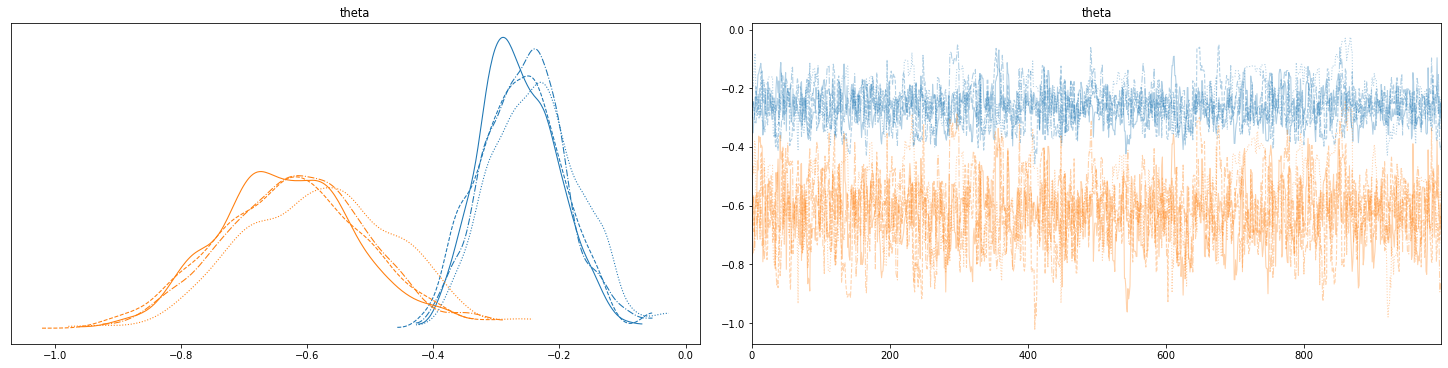

In [6]:
traceplot(trace, figsize=(20, 5));

---
We can convert the resulting `MultiTrace` object to `arviz.InferenceData` or the pyPESTO format using the following functions.

**NB**: in the `pypesto.Result` object the chain burn-in length is set to the number of tuning samples, unless `burn_in=None` is passed to the conversion function.

In [7]:
from pypesto.sample.pymc3_interface import pymc3_to_arviz, arviz_to_pypesto
azdata = pymc3_to_arviz(model, trace, problem=problem, save_warmup=True)
sampling_result = arviz_to_pypesto(problem, azdata, save_warmup=True)

---
Then, pyPESTO visualization routines can be used.

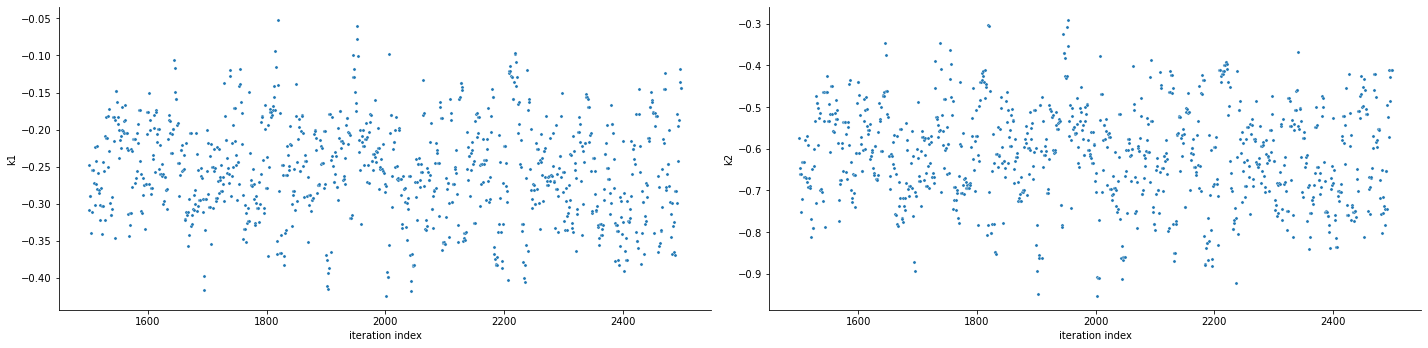

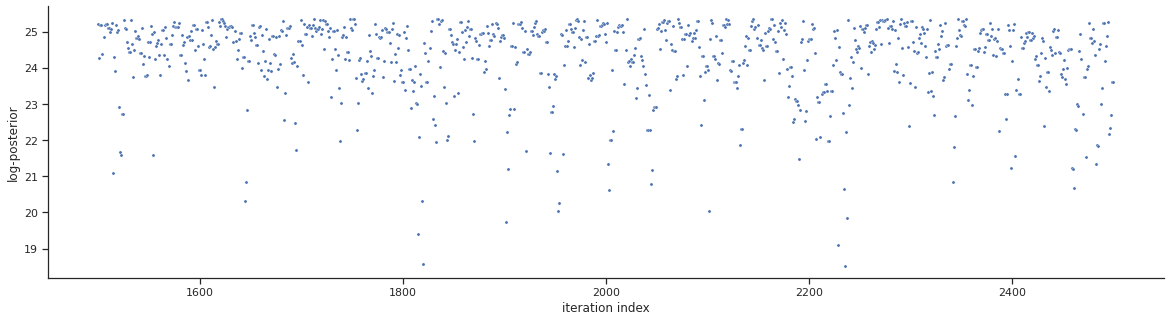

In [8]:
from pypesto import visualize
visualize.sampling_parameters_trace(sampling_result, use_problem_bounds=False, size=(20, 5));
visualize.sampling_fval_trace(sampling_result, size=(20, 5));

### Resuming sampling

PyMC3 default sampling functions do not allow to easily resume tuning/sampling. The helper class `ResumablePymc3Sampler` can be used instead.

First, create the PyMC3 model from the pyPESTO problem.

In [9]:
from pypesto.sample.pymc3_interface import create_pymc3_model
x0 = result.optimize_result.list[0]['x']
model = create_pymc3_model(problem, x0)

---
Then, initialize the PyMC3 step method (in this case NUTS).

In [10]:
from pypesto.sample.pymc3_interface import create_step_method
step, start = create_step_method(model, chains=1, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


---
Then, create a `ResumablePymc3Sampler`.

In [11]:
from pypesto.sample.pymc3_interface import ResumablePymc3Sampler
sampler = ResumablePymc3Sampler(model, start[0], step=step, tune=50, problem=problem)

* If the `backend` keyword argument is a string, then the sampling results will be saved in a HDF5 trace with that name.
  Otherwise, the trace backend will be automatically selected (usually defaults to `NDArray`).

* The `outvars` keyword argument determines which variables are to be saved. In this case, since we pass the pyPESTO problem with the `problem` keyword argument, this is automatically determined.

* The `tune` keyword argument determines the initial number of tuning steps. Since this sampler is resumable, this can be increased later.
---
We can then tune the sampler and plot the evolution of the step size.

**NB**: the current trace can be obtained through the `trace` property.

Tuning: 100%|██████████| 50/50 [00:01<00:00, 26.24it/s]


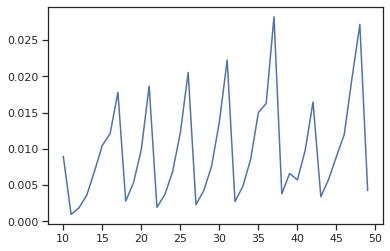

In [12]:
sampler.tune()

from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.plot(range(10, 50), sampler.trace.get_sampler_stats('step_size')[10:])

---
Calling tune again will have no effect, since tuning samples are exhausted.

In [13]:
sampler.tune()

---
However, since we have not started the sampling phase proper, we can still increase the number of tuning steps.

Tuning: 100%|██████████| 2500/2500 [00:54<00:00, 45.83it/s]


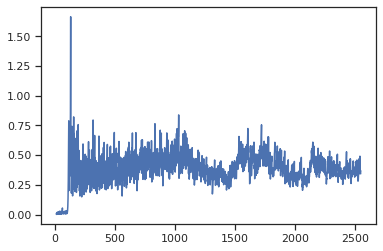

In [14]:
sampler.increase_tuning_samples(2500)
sampler.tune()

from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.plot(range(10, 2550), sampler.trace.get_sampler_stats('step_size')[10:])

---
By calling `.sample()` the tuning phase will no longer be extendable.

**NB**: calling `.sample()` will automatically call `.tune()` at its start.

In [15]:
sampler.sample(1000)

Sampling (0 divergences): 100%|██████████| 1000/1000 [00:21<00:00, 46.83it/s]


In [16]:
# This will raise an exception
# sampler.increase_tuning_samples(2500)

Exception: .sample(draws) has already been called: tuning is no longer possible.

---
If we pass the `warn=False` option to `sampler.sample` no warnings will be printed,
but we can manually report them at any later time (note: warnings are not written to disk).

In [17]:
sampler.log_sampler_warnings()

---
The sampler state can also be saved to disk as a `pickle` file (at the moment only possible with HDF5 backend).

In [18]:
# sampler.save('sampler.pickle')

In [19]:
# sampler = ResumablePymc3Sampler.load('sampler.pickle')

### Checkpointing sampling

It may also be useful to revert to a previous chain state, e.g., if at the end of sampling it becomes clear that the number of tuning samples was not enough.

This can be achieved with the `CheckpointablePymc3Sampler` helper class. This class accepts the same arguments as `ResumablePymc3Sampler`, apart for the first argument which must be a directory where to store the chain trace and all the checkpoints.

In [22]:
# Create PyMC3 Model
from pypesto.sample.pymc3_interface import create_pymc3_model
x0 = result.optimize_result.list[0]['x']
model = create_pymc3_model(problem, x0)

# Create PyMC3 step method
from pypesto.sample.pymc3_interface import create_step_method
step, start = create_step_method(model, chains=1, init='adapt_diag')

# CheckpointablePymc3Sampler
from pypesto.sample.pymc3_interface import CheckpointablePymc3Sampler
sampler = CheckpointablePymc3Sampler('pymc3_trace', model, start[0], step=step, tune=1, problem=problem, overwrite=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


---
The default branch is `'root'` and when inside a branch we can sample with the same interface as `ResumablePymc3Sampler`.

In [23]:
sampler.cur_branch

'root'

In [24]:
sampler.tune()

Tuning: 100%|██████████| 1/1 [00:00<00:00, 82.79it/s]


---
Before starting sampling, we create a new branch diverging from the current one.

In [25]:
sampler.fork_branch('samples_tune1')

In [26]:
sampler.load_branch('samples_tune1')

In [27]:
sampler.sample(100)

Sampling (100 divergences): 100%|██████████| 100/100 [00:01<00:00, 63.96it/s]


---
Since we obtained many divergences, the number of tuning samples was too small. We should discard this branch and continue tuning on the `'root'` branch.

In [28]:
sampler.delete_branch()

In [29]:
sampler.increase_tuning_samples(500)
sampler.tune()

Tuning: 100%|██████████| 500/500 [00:17<00:00, 28.07it/s]


In [30]:
sampler.fork_branch('samples_tune500', load=True)  # Shorthand for automatically loading a new branch
sampler.sample(100)

Sampling (0 divergences): 100%|██████████| 100/100 [00:03<00:00, 28.37it/s]


## Example (scalar)

Now we consider a scalar test problem of a gaussian mixture density, together with a flat prior.

In [31]:
import numpy as np
from scipy.stats import multivariate_normal
import seaborn as sns

import pypesto
import pypesto.sample as sample
import pypesto.visualize as visualize

def density(x):
    return 0.3*multivariate_normal.pdf(x, mean=-1.5, cov=0.1) + \
        0.7*multivariate_normal.pdf(x, mean=2.5, cov=0.2)

def nllh(x):
    return - np.log(density(x))

objective = pypesto.Objective(fun=nllh)
problem = pypesto.Problem(objective=objective, lb=-4, ub=5, x_names=['x'])

The likelihood has two separate modes:

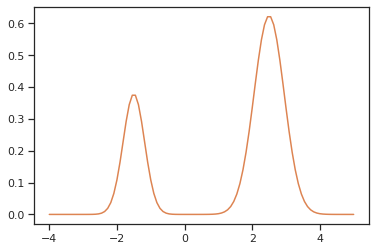

In [32]:
xs = np.linspace(-4, 5, 100)
ys = [density(x) for x in xs]

from matplotlib import pyplot as plt
ax = sns.lineplot(xs, ys, color='C1')
plt.show()

Sample with the PyMC3 interface and plot using pyPESTO visualization functions.

In [33]:
from pypesto import sample

sampler = sample.Pymc3Sampler(chains=4, tune=2000)

result = sample.sample(problem, 10_000, sampler, x0=np.asarray([0]))

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (4 chains in 4 jobs)
Slice: [x]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 45 seconds.


Burn-in detected by Geweke test: 0 samples


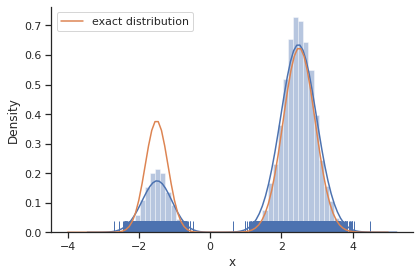

In [34]:
sample.geweke_test(result)

print(f"Burn-in detected by Geweke test: {result.sample_result['burn_in']} samples")

ax = visualize.sampling_1d_marginals(result);
ax[0][0].plot(xs, ys, label='exact distribution');
ax[0][0].legend();

## Example (Rosenbrock banana)

The adaptive parallel tempering sampler with chains running adaptive Metropolis samplers is also able to sample from more challenging posterior distributions. To illustrates this shortly, we use the Rosenbrock function.

In [35]:
import numpy as np
from scipy.optimize import rosen
import pypesto

# first type of objective
objective = pypesto.Objective(fun=rosen)

dim_full = 4
lb = -5 * np.ones((dim_full, 1))
ub = 5 * np.ones((dim_full, 1))

problem = pypesto.Problem(objective=objective, lb=lb, ub=ub)

In [36]:
from pypesto import sample

sampler = sample.Pymc3Sampler(chains=4, tune=2000)

x0 = np.zeros(problem.dim)
result = sample.sample(problem, 1_000, sampler, x0=x0)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (4 chains in 4 jobs)
Slice: [theta]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


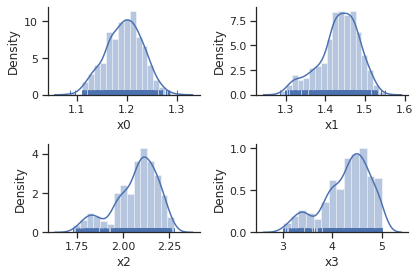

In [37]:
from pypesto import sample, visualize
pypesto.sample.geweke_test(result)
visualize.sampling_1d_marginals(result);